# Analysis of processed vector current velocity data

Lachlan Perris 23/01/2024

In [39]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import find_peaks
import netCDF4
import xarray as xr
from datetime import datetime, timedelta
import os
import matplotlib.colors as mcolors

colours = ['#377eb8','#ff7f00','#984ea3']

C:\Users\lachl\AppData\Local\Temp\ipykernel_38436\374079737.py:7: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [10]:
#def smooth_line(data, sigma = 2000):
#    return gaussian_filter1d(data, sigma)

def smooth_line(ncdata, times = '0.25h'):
    return ncdata.resample(time=times).mean()


def quickplot(ncdata, var = 'vel', direction = 1, smooth_tide=False):

    if direction == 0:
        cflow = 'red'
        direc = 'X'
        print('Velocity in X direction')
    if direction == 1:
        cflow = 'darkred'
        direc = 'Y'
        print('Velocity in Y direction')
    if direction == 2:
        cflow = 'orange'
        direc = 'Vertical'
        print('Veloicty in vertical direction')

    fig, ax = plt.subplots(figsize=(10,5))

    ax2 = ax.twinx()
    ax2.plot(ncdata.variables['time'],ncdata.variables[var][direction], c= cflow, label = 'Current velocity (m/s)')
    
    if smooth_tide:
        tide = smooth_line(ncdata)
        ax.plot(tide.variables['time'],tide['depth'], label = 'Depth (m)')
    else:
        ax.plot(ncdata.variables['time'],ncdata.variables['depth'][:], label = 'Depth (m)')
    pass
  
    plt.title('%s Flow velocity and tide at %s'%(direc, ncdata.deployment_name)) 
    ax.set_ylabel('Depth $(m)$')
    ax2.set_ylabel('Flow velocity $(ms^-1)$')
    
    
    ax.legend(loc = 2)
    ax2.legend(loc = 0)
    plt.grid()
    plt.show()

In [11]:
#Set start and end times:


start = '2022-10-06 23:00:00'
end  = '2022-10-07 04:00:00'

def sliced_plot(data,start,end, smooth_tide = False):
    ds_slice = data.sel(time=slice(start,end))
    quickplot(ds_slice,'pressure', direction = 1, smooth_tide=smooth_tide)
    
    
    print('Data from period %s to %s'%(start,end))
    if (ds_slice.vel[1].mean(skipna=True).values) > 0:
        print('Mean flow is offshore at  %s m/s'%(np.absolute(ds_slice.vel[1].mean(skipna=True).values)))
    else:
        print('Mean flow is onshore at %s m/s'%(np.absolute(ds_slice.vel[1].mean(skipna=True).values)))  
    print('Max offshore velocity: %s m/s' %(np.absolute(ds_slice.vel[1].max(skipna=True).values)))
    print('Max onshore velocity: %s m/s' %(np.absolute(ds_slice.vel[1].min(skipna=True).values)))
    
    
    

In [12]:
def get_direction(direction):
    if direction == 0:
        cflow = 'red'
        direc = 'X'
        print('Veloicty in X direction')
    if direction == 1:
        cflow = 'darkred'
        direc = 'Y'
        print('Velocity in Y direction')
    if direction == 2:
        cflow = 'orange'
        direc = 'Vertical'
        print('Veloicty in vertical direction')
    return cflow, direc
 

In [14]:
#os.chdir('20221008_OTR_Data')

ds = xr.open_dataset( r'..\Data_final\20250123_instrument_A1_data.nc')
ds2 = xr.open_dataset( r'..\Data_final\20250123_instrument_A2_data.nc')



Velocity in X direction


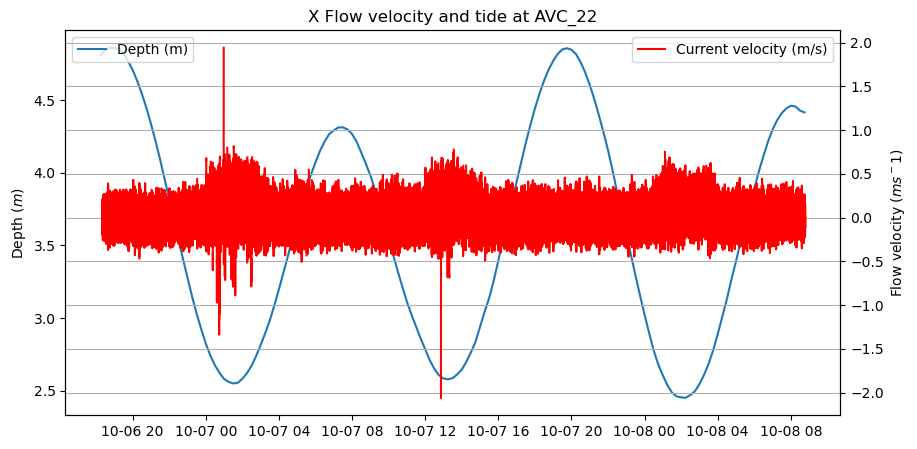

Velocity in Y direction


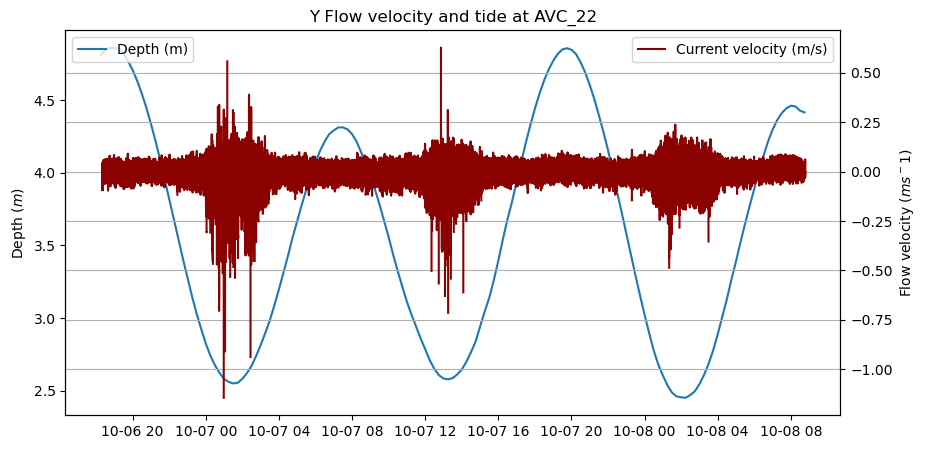

Veloicty in vertical direction


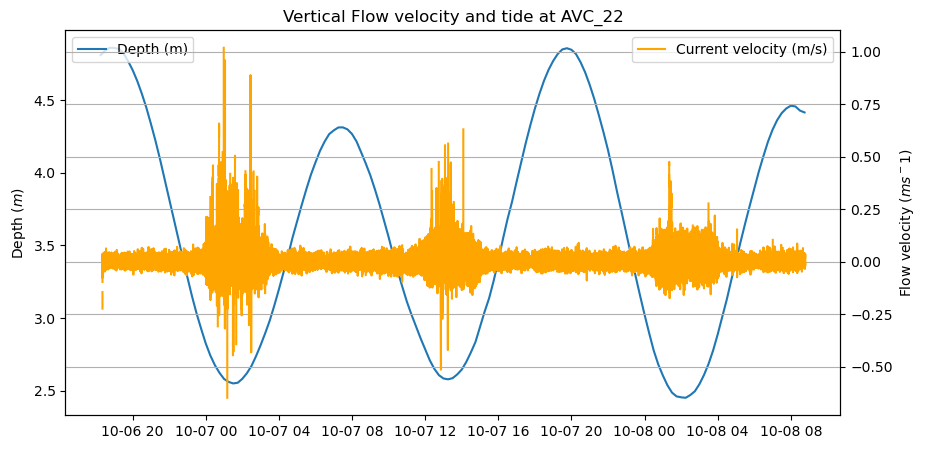

In [18]:
quickplot(ds, 'vel', direction = 0, smooth_tide=True)
quickplot(ds, 'vel', direction = 1, smooth_tide=True)
quickplot(ds, 'vel', direction = 2, smooth_tide=True)

Velocity in X direction


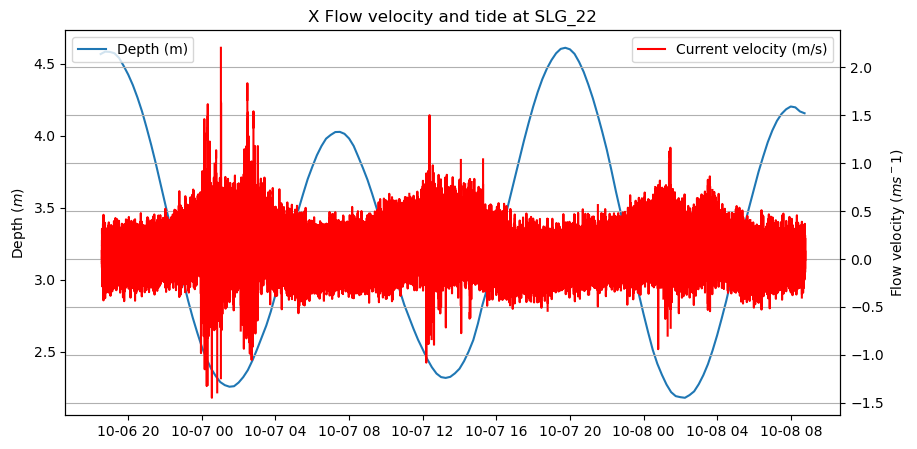

Velocity in Y direction


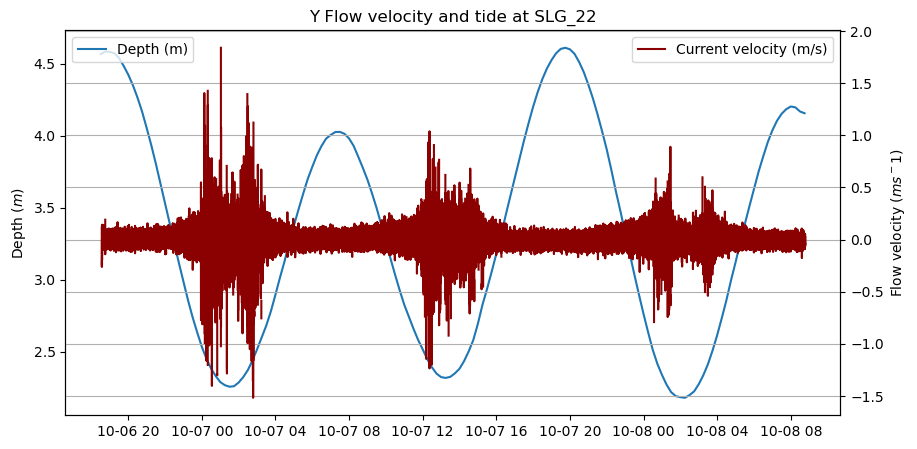

Veloicty in vertical direction


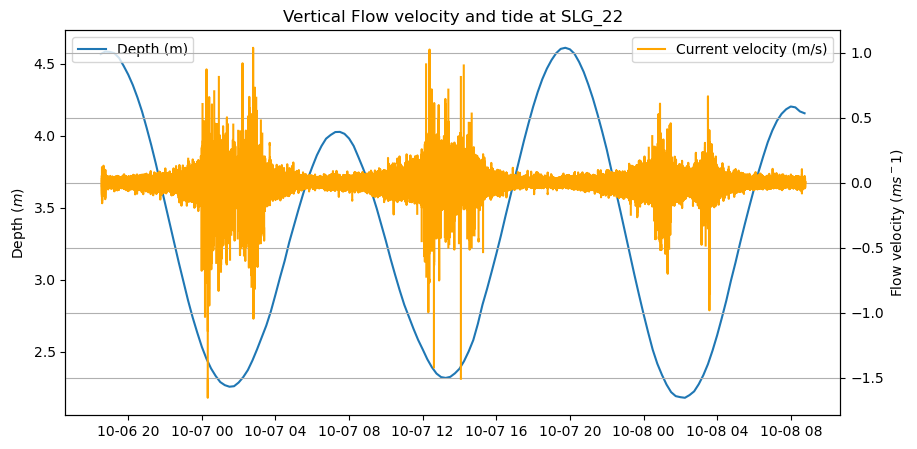

In [20]:
quickplot(ds2, 'vel', direction = 0, smooth_tide=True)
quickplot(ds2, 'vel', direction = 1, smooth_tide=True)
quickplot(ds2, 'vel', direction = 2, smooth_tide=True)

In [21]:
# Calculate the absolute magnitude of the flow:

u = ds.variables["vel"][0]
v = ds.variables["vel"][1]
w = ds.variables["vel"][2]


ds['vel_mag2D'] = np.sqrt(u**2 + v**2)
ds['polar_angle'] = np.degrees(np.arctan2(v,u))
ds['vel_mag3D'] = np.sqrt(u**2 + v**2 + w**2)
ds['elevation'] = np.degrees(np.arcsin(w / ds['vel_mag3D']))
ds['azimuth'] = np.degrees(np.arctan2(v, u))


u = ds2.variables["vel"][0]
v = ds2.variables["vel"][1]
w = ds2.variables["vel"][2]


ds2['vel_mag2D'] = np.sqrt(u**2 + v**2)
ds2['polar_angle'] = np.degrees(np.arctan2(v,u))
ds2['vel_mag3D'] = np.sqrt(u**2 + v**2 + w**2)
ds2['elevation'] = np.degrees(np.arcsin(w / ds2['vel_mag3D']))
ds2['azimuth'] = np.degrees(np.arctan2(v, u))



# resample

In [23]:
ds_rsp_max = ds.resample(time="0.25h").max()
ds_rsp_mean = ds.resample(time="0.25h").mean()
ds_rsp_min = ds.resample(time="0.25h").min()

ds2_rsp_max = ds2.resample(time="0.25h").max()
ds2_rsp_mean = ds2.resample(time="0.25h").mean()
ds2_rsp_min = ds2.resample(time="0.25h").min()


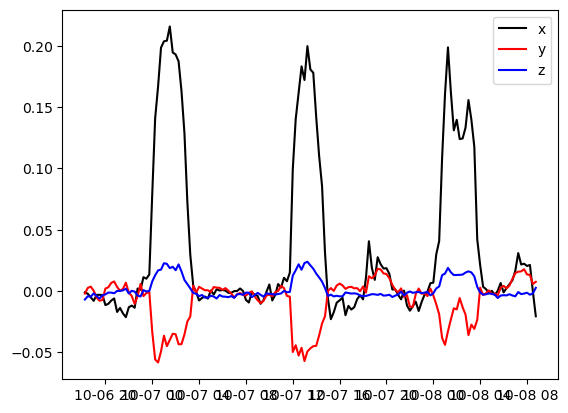

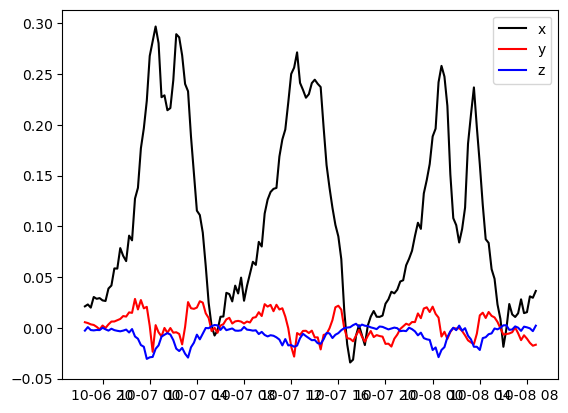

In [24]:
plt.plot(ds_rsp_max.time, ds_rsp_mean.vel[:, 0], color='k', label='x')
plt.plot(ds_rsp_max.time, ds_rsp_mean.vel[:, 1], color='r', label='y')
plt.plot(ds_rsp_max.time, ds_rsp_mean.vel[:, 2], color='b', label='z')
plt.legend()
plt.show()

plt.plot(ds2_rsp_max.time, ds2_rsp_mean.vel[:, 0], color='k', label='x')
plt.plot(ds2_rsp_max.time, ds2_rsp_mean.vel[:, 1], color='r', label='y')
plt.plot(ds2_rsp_max.time, ds2_rsp_mean.vel[:, 2], color='b', label='z')
plt.legend()
plt.show()

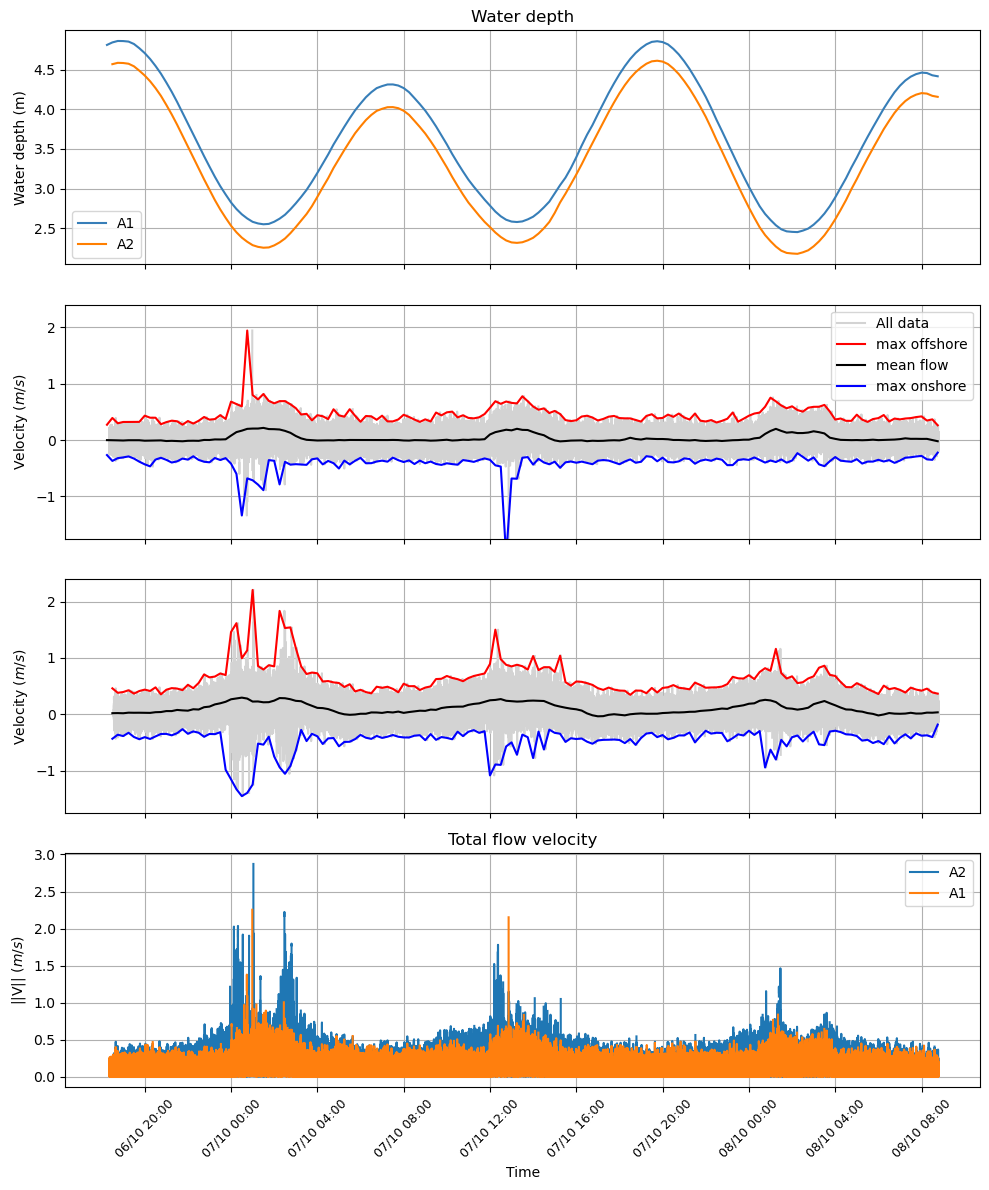

In [25]:
import matplotlib.dates as mdates  # Import the module for date formatting

fig, (ax, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(10, 12), sharex=True)  # Create a 2x1 grid of subplots that share the same X-axis

#Plot 1
ax.plot(ds_rsp_mean.variables['time'],ds_rsp_mean.variables['depth'],  c = colours[0], label = 'A1')
ax.plot(ds2_rsp_mean.variables['time'],ds2_rsp_mean.variables['depth'], c=colours[1], label = 'A2')


ax.grid()
ax.set_ylabel('Water depth (m)')
ax.set_title('Water depth')
ax.legend()

# Plot 1

direction = 0
ax1.plot(ds.variables['time'], ds.variables['vel'][direction], label='All data', color='lightgrey')
ax1.plot(ds_rsp_max.time, ds_rsp_max.vel[:, direction], c='r', label='max offshore')
ax1.plot(ds_rsp_max.time, ds_rsp_mean.vel[:, direction], color='k', label='mean flow')
ax1.plot(ds_rsp_max.time, ds_rsp_min.vel[:, direction], color='b', label='max onshore')
ax1.set_ylabel('Velocity $(m/s)$')
ax1.set_ylim(-1.75,2.4)
ax1.grid()

# Plot 2
direction = 0
ax2.plot(ds2['time'], ds2.variables['vel'][direction], label='All data', color='lightgrey')
ax2.plot(ds2_rsp_max.time, ds2_rsp_max.vel[:, direction], c='r', label='max offshore')
ax2.plot(ds2_rsp_max.time, ds2_rsp_mean.vel[:, direction], color='k', label='mean flow')
ax2.plot(ds2_rsp_max.time, ds2_rsp_min.vel[:, direction], color='b', label='max onshore')

ax2.set_ylabel('Velocity $(m/s)$')
ax2.set_ylim(-1.75,2.4)
ax2.grid()

#Plot 1
ax3.plot(ds2['time'],(ds2['vel_mag2D']), label = 'A2')
ax3.plot(ds['time'],(ds['vel_mag2D']), label = 'A1')
ax3.grid()
ax3.set_ylabel('||V|| $(m/s)$')
ax3.set_title('Total flow velocity')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:00'))
ax3.tick_params(axis='x', labelsize=9, rotation = 45) 
ax3.set_xlabel('Time')  # Set X-axis label for the bottom subplot
ax3.legend()

# Set a common legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels)

plt.tight_layout()  # Ensures that subplots do not overlap
plt.show()








In [26]:
print('Summary data')

dsmax = ds['vel_mag2D'].max().values
ds_off_max = ds['vel'][0].max().values
ds_on_max = ds['vel'][0].min().values
ds_mean = ds['vel_mag2D'].mean().values


print('Instrument 1')
print(f' Maximum flow rate at A1: {dsmax}')
print(f' Maximum offshore flow rate at A1: {ds_off_max}')
print(f' Maximum onshore flow rate at A1: {ds_on_max}')
print(f' Mean flow rate at A1: {ds_mean}')



dsmax = ds2['vel_mag2D'].max().values
ds_off_max = ds2['vel'][0].max().values
ds_on_max = ds2['vel'][0].min().values
ds_mean = ds2['vel_mag2D'].mean().values

print('Instrument 2')
print(f' Maximum flow rate at A2: {dsmax}')
print(f' Maximum offshore flow rate at A2: {ds_off_max}')
print(f' Maximum onshore flow rate at A2: {ds_on_max}')
print(f' Mean flow rate at A2: {ds_mean}')

Summary data
Instrument 1
 Maximum flow rate at A1: 2.253873825073242
 Maximum offshore flow rate at A1: 1.941720724105835
 Maximum onshore flow rate at A1: -2.0586647987365723
 Mean flow rate at A1: 0.12015291303396225
Instrument 2
 Maximum flow rate at A2: 2.871790885925293
 Maximum offshore flow rate at A2: 2.2051539421081543
 Maximum onshore flow rate at A2: -1.4486312866210938
 Mean flow rate at A2: 0.17074428498744965


In [27]:
### Find low tide times. This was done previously and put into a df called df_intervals.

df_tides = pd.read_csv(r'..\Data_final\20250123_tidal_intervals.csv')
df_tides


,Unnamed: 0,time,depth,start,end,duration,interval,cat1,cat2,cat3
0,0,2022-10-06 19:02:06.999541,4.864288,2022-10-06 19:02:06.999541,2022-10-06 22:31:38.874652,0 days 03:29:31.875111,1,high falling,high,falling
1,1,2022-10-06 22:31:38.874652,3.603790,2022-10-06 22:31:38.874652,2022-10-07 01:39:45.749752,0 days 03:08:06.875100,2,low falling,low,falling
2,2,2022-10-07 01:39:45.749752,2.557291,2022-10-07 01:39:45.749752,2022-10-07 04:58:32.124857,0 days 03:18:46.375105,3,low rising,low,rising
3,3,2022-10-07 04:58:32.124857,3.603800,2022-10-07 04:58:32.124857,2022-10-07 07:31:12.874938,0 days 02:32:40.750081,4,high rising,high,rising
4,4,2022-10-07 07:31:17.249938,4.314948,2022-10-07 07:31:17.249938,2022-10-07 10:01:47.875018,0 days 02:30:30.625080,5,high falling,high,falling
5,5,2022-10-07 10:01:47.875018,3.603799,2022-10-07 10:01:47.875018,2022-10-07 13:21:21.750124,0 days 03:19:33.875106,6,low falling,low,falling
6,6,2022-10-07 13:21:21.750124,2.586361,2022-10-07 13:21:21.750124,2022-10-07 16:28:52.750223,0 days 03:07:31.000099,7,low rising,low,rising
7,7,2022-10-07 16:28:52.750223,3.603789,2022-10-07 16:28:52.750223,2022-10-07 19:51:41.500331,0 days 03:22:48.750108,8,high rising,high,rising
8,8,2022-10-07 19:51:41.500331,4.858463,2022-10-07 19:51:41.500331,2022-10-07 23:05:38.375434,0 days 03:13:56.875103,9,high falling,high,falling
9,9,2022-10-07 23:05:38.375434,3.603796,2022-10-07 23:05:38.375434,2022-10-08 02:14:24.750534,0 days 03:08:46.375100,10,low falling,low,falling


In [28]:
def split_tides(ds, df_tides):
    # Filter the DataFrame to get time intervals for low tide
    low_tide_intervals = df_tides[df_tides['cat2'] == 'low']

    # Initialize an empty list to store flow rates
    low_tide_flow_rates = []

    # Iterate through the low tide intervals and select the corresponding flow rates
    for index, row in low_tide_intervals.iterrows():
        start_time = row['start']
        end_time = row['end']

        # Use xarray's sel method to select flow rates within the low tide interval
        low_tide_data = ds.sel(time=slice(start_time, end_time))

        # Append the selected flow rates to the list
        low_tide_flow_rates.append(low_tide_data)

    # Merge the selected low tide flow rates into a single xarray dataset
    low_tide_flow_data = xr.concat(low_tide_flow_rates, dim='time')
    
    
        # Filter the DataFrame to get time intervals for high tide
    high_tide_intervals = df_tides[df_tides['cat2'] == 'high']

    # Initialize an empty list to store flow rates
    high_tide_flow_rates = []

    # Iterate through the high tide intervals and select the corresponding flow rates
    for index, row in high_tide_intervals.iterrows():
        start_time = row['start']
        end_time = row['end']

        # Use xarray's sel method to select flow rates within the high tide interval
        high_tide_data = ds.sel(time=slice(start_time, end_time))

        # Append the selected flow rates to the list
        high_tide_flow_rates.append(high_tide_data)

    # Merge the selected high tide flow rates into a single xarray dataset
    high_tide_flow_data = xr.concat(high_tide_flow_rates, dim='time')
    # Now, 'high_tide_flow_data' contains the flow rates at high tide intervals.
    return low_tide_flow_data, high_tide_flow_data

ds_low_tide, ds_high_tide = split_tides(ds, df_tides)
ds2_low_tide, ds2_high_tide = split_tides(ds2, df_tides)


In [29]:
mean_flow_rate_high = ds_high_tide['vel_mag2D'].mean()
mean_flow_rate_low = ds_low_tide['vel_mag2D'].mean()


print('Inst A1')


# Calculate the percentage increase
percentage_increase = ((mean_flow_rate_low - mean_flow_rate_high) / mean_flow_rate_high) * 100

# Print the results
print("Mean Flow Rates:")
print(f"High Tide: {mean_flow_rate_high.values:.2f}")
print(f"Low Tide: {mean_flow_rate_low.values:.2f}")
print(f"Percentage Increase from High Tide to Low Tide: {percentage_increase.values:.2f}%")


print('Inst A2')

mean_flow_rate_high = ds2_high_tide['vel_mag2D'].mean()
mean_flow_rate_low = ds2_low_tide['vel_mag2D'].mean()

# Calculate the percentage increase
percentage_increase = ((mean_flow_rate_low - mean_flow_rate_high) / mean_flow_rate_high) * 100

# Print the results
print("Mean Flow Rates:")
print(f"High Tide: {mean_flow_rate_high.values:.2f}")
print(f"Low Tide: {mean_flow_rate_low.values:.2f}")
print(f"Percentage Increase from High Tide to Low Tide: {percentage_increase.values:.2f}%")


Inst A1
Mean Flow Rates:
High Tide: 0.09
Low Tide: 0.15
Percentage Increase from High Tide to Low Tide: 54.67%
Inst A2
Mean Flow Rates:
High Tide: 0.12
Low Tide: 0.22
Percentage Increase from High Tide to Low Tide: 89.89%


In [30]:


print("ALL DATA:")
mean_flow_rate_high = ds_high_tide['vel_mag2D'].mean()
mean_flow_rate_low = ds_low_tide['vel_mag2D'].mean()


print('Inst A1')


# Calculate the percentage increase
percentage_increase = ((mean_flow_rate_low - mean_flow_rate_high) / mean_flow_rate_high) * 100

# Print the results
print("Mean Flow vels:")
print(f" All data: {ds['vel_mag2D'].mean():.2f}")
print(f"mean cross-shore flow velocity: {ds['vel'][0].mean():.2f}")
print(f"mean cross-shore flow velocity low tide: {ds_low_tide['vel'][0].mean():.2f}")
print(f"mean cross-shore flow velocity high tide: {ds_high_tide['vel'][0].mean():.2f}")
print(f"High Tide all flow: {mean_flow_rate_high.values:.2f}")
print(f"Low Tide all flow: {mean_flow_rate_low.values:.2f}")
print(f"Percentage Increase from High Tide to Low Tide: {percentage_increase.values:.2f}%")

print(" ")

print('Inst A2')

mean_flow_rate_high = ds2_high_tide['vel_mag2D'].mean()
mean_flow_rate_low = ds2_low_tide['vel_mag2D'].mean()

# Calculate the percentage increase
percentage_increase = ((mean_flow_rate_low - mean_flow_rate_high) / mean_flow_rate_high) * 100

# Print the results
print("Flow vels:")
print(f" All data mean: {ds2['vel_mag2D'].mean():.2f}")
print(f"mean cross-shore flow velocity: {ds2['vel'][0].mean():.2f}")
print(f"mean cross-shore flow velocity low tide: {ds2_low_tide['vel'][0].mean():.2f}")
print(f"mean cross-shore flow velocity high tide: {ds2_high_tide['vel'][0].mean():.2f}")
print(f"High Tide all flow: {mean_flow_rate_high.values:.2f}")
print(f"Low Tide all flow: {mean_flow_rate_low.values:.2f}")
print(f"Percentage Increase from High Tide to Low Tide: {percentage_increase.values:.2f}%")

ALL DATA:
Inst A1
Mean Flow vels:
 All data: 0.12
mean cross-shore flow velocity: 0.04
mean cross-shore flow velocity low tide: 0.07
mean cross-shore flow velocity high tide: -0.00
High Tide all flow: 0.09
Low Tide all flow: 0.15
Percentage Increase from High Tide to Low Tide: 54.67%
 
Inst A2
Flow vels:
 All data mean: 0.17
mean cross-shore flow velocity: 0.11
mean cross-shore flow velocity low tide: 0.18
mean cross-shore flow velocity high tide: 0.03
High Tide all flow: 0.12
Low Tide all flow: 0.22
Percentage Increase from High Tide to Low Tide: 89.89%


In [32]:
mean_flow_rate_high = ds_high_tide['vel'][0].mean()
mean_flow_rate_low = ds_low_tide['vel'][0].mean()
print("Mean OFFSHORE Flow Rates:")
print(f"High Tide: {mean_flow_rate_high.values:.2f}")
print(f"Low Tide: {mean_flow_rate_low.values:.2f}")


print('ds, all data')
mean_flow_rate = -ds2['vel'][2].mean()
print(f"Mean Flow Rates: {mean_flow_rate.values:.2f}")

print('')
print('ds2')
mean_flow_rate_high = ds2_high_tide['vel'][0].mean()
mean_flow_rate_low = ds2_low_tide['vel'][0].mean()
print("Mean OFFSHORE Flow Rates:")
print(f"High Tide: {mean_flow_rate_high.values:.2f}")
print(f"Low Tide: {mean_flow_rate_low.values:.2f}")

print('ds2, all data')
mean_flow_rate = -ds2['vel'][1].mean()

print(f"Mean Flow Rates: {mean_flow_rate.values:.2f}")


Mean OFFSHORE Flow Rates:
High Tide: -0.00
Low Tide: 0.07
ds, all data
Mean Flow Rates: 0.01

ds2
Mean OFFSHORE Flow Rates:
High Tide: 0.03
Low Tide: 0.18
ds2, all data
Mean Flow Rates: -0.00


In [33]:
# Find the index of the maximum value in 'vel_mag2D'
max_index = ds['vel_mag2D'].argmax().item()

# Get the corresponding 'polar_angle' value
corresponding_polar_angle = ds['polar_angle'][max_index].item()
print("A1")
print("The highest value of 'vel_mag2D' is:", ds['vel_mag2D'][max_index].item())
print("The corresponding 'polar_angle' is:", corresponding_polar_angle + 180) # Plus 180 as the result is negative

print("")
print("A2")
# Find the index of the maximum value in 'vel_mag2D'
max_index = ds2['vel_mag2D'].argmax().item()

# Get the corresponding 'polar_angle' value
corresponding_polar_angle = ds2['polar_angle'][max_index].item()

print("The highest value of 'vel_mag2D' is:", ds2['vel_mag2D'][max_index].item())
print("The corresponding 'polar_angle' is:", corresponding_polar_angle) # Result is positive does not need + 180

A1
The highest value of 'vel_mag2D' is: 2.253873825073242
The corresponding 'polar_angle' is: 149.48584175109863

A2
The highest value of 'vel_mag2D' is: 2.871790885925293
The corresponding 'polar_angle' is: 39.83725357055664


In [34]:
# Assuming ds_low_tide is your dataset and 'vel_mag3D' is the relevant variable
vel_mag3D_values = ds_low_tide['vel_mag3D'].values

# Remove NaN values
valid_values = vel_mag3D_values[~np.isnan(vel_mag3D_values)]

# Calculate the mean flow rate
mean_flow_rate_low = np.mean(valid_values)

# Assuming ds_high_tide is your dataset and 'vel_mag3D' is the relevant variable
vel_mag3D_values_high = ds_high_tide['vel_mag3D'].values

# Remove NaN values for high tide
valid_values_high = vel_mag3D_values_high[~np.isnan(vel_mag3D_values_high)]

# Calculate the mean flow rate at high tide
mean_flow_rate_high = np.mean(valid_values_high)

percentage_change = ((mean_flow_rate_low - mean_flow_rate_high) / mean_flow_rate_high) * 100
print("A1:")
print(f"Mean flow rate at low tide: {mean_flow_rate_low}")
print(f"Mean flow rate at high tide: {mean_flow_rate_high}")
print(f"Percentage change from high tide to low tide flow rates: {percentage_change:.2f}%")

print("")
print("A2:")
# Assuming ds_low_tide is your dataset and 'vel_mag3D' is the relevant variable
vel_mag3D_values = ds2_low_tide['vel_mag3D'].values

# Remove NaN values
valid_values = vel_mag3D_values[~np.isnan(vel_mag3D_values)]

# Calculate the mean flow rate
mean_flow_rate_low = np.mean(valid_values)

# Assuming ds_high_tide is your dataset and 'vel_mag3D' is the relevant variable
vel_mag3D_values_high = ds2_high_tide['vel_mag3D'].values

# Remove NaN values for high tide
valid_values_high = vel_mag3D_values_high[~np.isnan(vel_mag3D_values_high)]

# Calculate the mean flow rate at high tide
mean_flow_rate_high = np.mean(valid_values_high)

percentage_change = ((mean_flow_rate_low - mean_flow_rate_high) / mean_flow_rate_high) * 100

print(f"Mean flow rate at low tide: {mean_flow_rate_low}")
print(f"Mean flow rate at high tide: {mean_flow_rate_high}")
print(f"Percentage change from high tide to low tide flow rates: {percentage_change:.2f}%")

A1:
Mean flow rate at low tide: 0.14984719455242157
Mean flow rate at high tide: 0.09572562575340271
Percentage change from high tide to low tide flow rates: 56.54%

A2:
Mean flow rate at low tide: 0.23106175661087036
Mean flow rate at high tide: 0.11978546530008316
Percentage change from high tide to low tide flow rates: 92.90%


## Radial plots

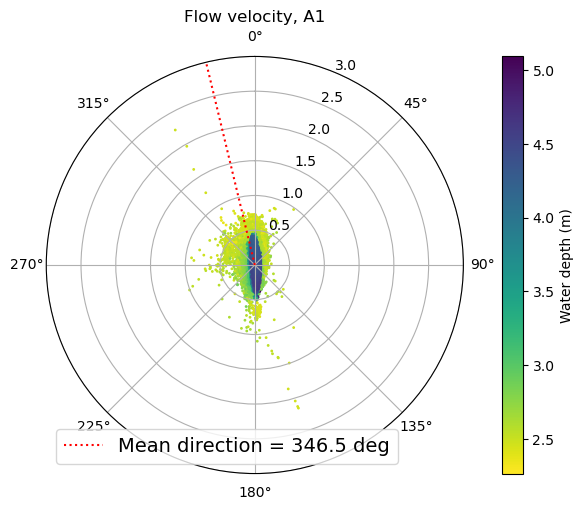

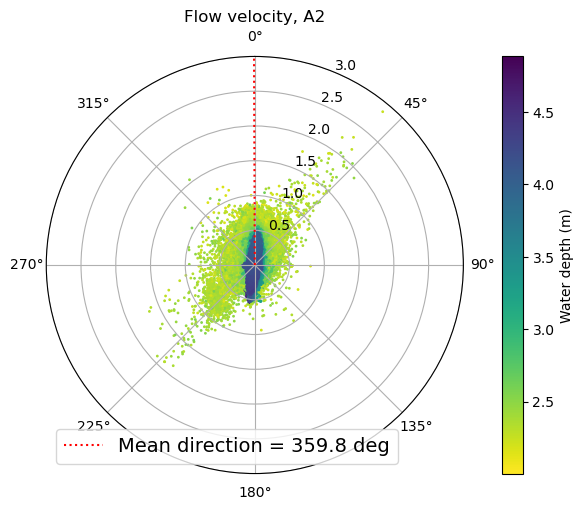

In [41]:
def radial_plot(ds, rmax):
    u = ds.variables["vel"][0]
    v = ds.variables["vel"][1]
    resultant_vector = np.sqrt(u**2 + v**2)
    direction = np.degrees(np.arctan2(v, u))

    direction_rad = np.deg2rad(direction)
    
    # Calculate the circular mean
    circular_mean = np.arctan2(np.mean(np.sin(direction_rad)), np.mean(np.cos(direction_rad)))

    # Convert the circular mean back to degrees
    circular_mean_deg = np.rad2deg(circular_mean)

    # Create a polar scatter plot
    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    # Convert from -180 to 180 to 0 to 360
    if circular_mean_deg < 0:
        mean_dir_print = circular_mean_deg + 360
    else:
        mean_dir_print = circular_mean_deg
        
    # Sample data for demonstration
    depth_values = ds['depth'].values

    reversed_cmap = plt.cm.viridis_r
    
    sc = ax.scatter(direction_rad, resultant_vector, c=depth_values,cmap=reversed_cmap, s=1)
    
    ax.plot([circular_mean, circular_mean], [0, rmax], c='r', linestyle='dotted', label=f"Mean direction = {mean_dir_print:.1f} deg")
    
    # Add a colorbar for reference
    norm = mcolors.Normalize(vmin=np.min(depth_values), vmax=np.max(depth_values))

    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis_r, norm=norm)  # Use the reversed colormap
    sm.set_array([])  # Only needed for the colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Water depth (m)')
        
    # Set font size for legend and axis labels
    ax.legend(loc=3, fontsize=14)  # Adjust legend font size
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)  # Adjust x-axis label font size
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)  # Adjust y-axis label font size

    ax.set_theta_zero_location("N")  # This places 0 degrees at North
    ax.set_theta_direction(-1)  # Counterclockwise direction

    ax.set_rmax(rmax)
    plt.tight_layout()
    
    
radial_plot(ds, rmax=3)
plt.title('Flow velocity, A1')
plt.show()


radial_plot(ds2, rmax=3)
plt.title('Flow velocity, A2')
plt.show()
